In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install torch transformers datasets evaluate pillow
!pip install git+https://github.com/rwightman/pytorch-image-models.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-t0emng1z
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-t0emng1z
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit e44f14d7d2f557b9f3add82ee4f1ed2beefbb30d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-1.0.15-py3-none-any.whl size=2361373 sha256=5a3dc460c24e322ecc7fd1f3e3eb112423ddee320cb059cc1956fbc9731748ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-3733cwgl/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-

In [44]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil

In [45]:
train_files = glob.glob("/kaggle/input/signal-pose-prediction/train/train/*")
# train_files_list.append(train_files)

test_files = glob.glob("/kaggle/input/signal-pose-prediction/test/test/*")

In [46]:
# Transform image data based on ImageNet's mean and std
transforms = {
    "train": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

# Signal Preprocessing to convert into images

Using summation

In [10]:
image_array = np.load(train_files[0])

print(image_array.shape)

# Merge the channels by averaging
# merged_image = np.mean(image_array, axis=-1)
merged_image = np.sum(image_array, axis=-1)

# Convert the numpy array to a PIL Image
image_pil = Image.fromarray((merged_image * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

# Convert single-channel image to three-channel image
image_rgb = Image.merge("RGB", (image_pil, image_pil, image_pil))

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()

(2560, 56, 2)


Mixing 

(2560, 56, 2)


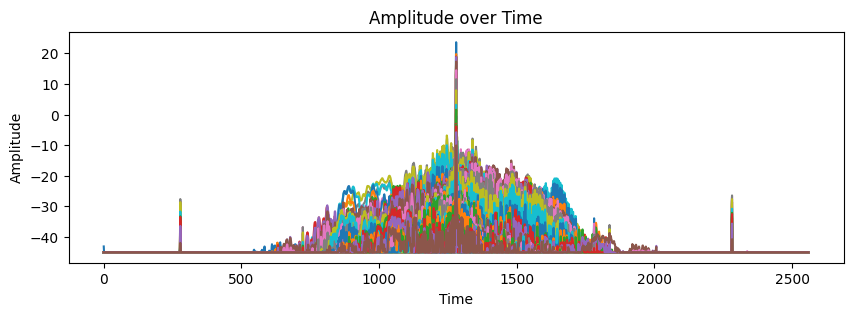

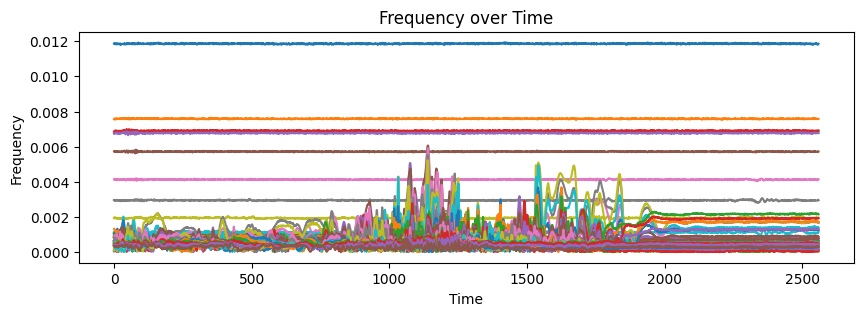

(2560, 56, 3)


In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image array
image_array = np.load(train_files[2])

print(image_array.shape)  # Should print (2560, 56, 2)

# Separate amplitude and frequency channels
amplitude = image_array[:, :, 0]
frequency = image_array[:, :, 1]

# Plot amplitude over time
plt.figure(figsize=(10, 3))
plt.title('Amplitude over Time')
plt.plot(amplitude)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot frequency over time
plt.figure(figsize=(10, 3))
plt.title('Frequency over Time')
plt.plot(frequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Combine amplitude and frequency channels
combined_image = np.stack((amplitude, frequency), axis=-1)

# Create a zero-filled channel
zero_channel = np.zeros_like(amplitude)

# Merge amplitude, frequency, and zero-filled channels
final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

print(final_image.shape)

# Convert the numpy array to a PIL Image
image_pil = Image.fromarray((final_image * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

# Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide the axis
plt.show()

In [21]:
# Convert a tensor or an ndarray to PIL Image
toImage = T.ToPILImage()

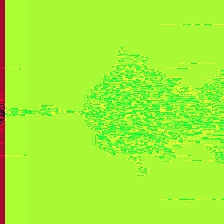

In [24]:
# Display an example of transform images
toImage(transforms["train"](image_pil))

In [50]:
import numpy as np
import scipy.signal as signal

# Band-pass filter
def bp_filter_signal(complex_img, low=0.008, high=0.1):
  """
  : Description :   Filter image with band pass filter
  : Input :
    - complex_img   2D array of complex number
    - low           minimum frequency to collect
    - high          maximum frequency to collect
  : Output :
    - filter_img    result image after filtering
  """

  # === Band-pass filter === #
  img_fft = np.fft.fft2(complex_img)

  low_cutoff = low
  high_cutoff = high

  # Create a mask for the filter function
  ny, nx = img_fft.shape
  u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
  d = np.sqrt(u**2 + v**2)
  mask = np.logical_and(d > low_cutoff, d < high_cutoff)

  # Apply the filter to the Fourier transform
  bp_img = img_fft * mask

  # Compute the inverse Fourier transform to get the filtered image
  filter_img = np.fft.ifft2(bp_img).real
  return filter_img

# High-pass then Band-pass filter
def hpbp_filter_signal(complex_img, high_cut=0.0005, low=0.008, high=0.1):
  """
  : Description :   Filter image with High-pass filter then filter with band-pass filter
  : Input :
    - complex_img   2D array of complex number
    - high_cut      maximum frequency to collect from high-pass filter
    - low           minimum frequency to collect from band-pass filter
    - high          maximum frequency to collect from band-pass filter
  : Output :
    - filter_img    result image after filtering
  """
  # === High-pass filter === #
  filter_order = 3
  b, a = signal.butter(filter_order, high_cut, 'high')
  hp_img = signal.filtfilt(b, a, complex_img)

  # === Band-pass filter === #
  img_fft = np.fft.fft2(hp_img)
  low_cutoff = low
  high_cutoff = high

  # Create a mask for the filter function
  ny, nx = img_fft.shape
  u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
  d = np.sqrt(u**2 + v**2)
  mask = np.logical_and(d > low_cutoff, d < high_cutoff)

  # Apply the filter to the Fourier transform
  bp_img = img_fft * mask

  # Compute the inverse Fourier transform to get the filtered image
  filter_img = np.fft.ifft2(bp_img).real
  return filter_img

# Band-pass then High-pass filter
def bphp_filter_signal(complex_img, high_cut=0.0005, low=0.008, high=0.1):
  """
  : Description :   Filter image with Band-pass filter then filter with High-pass filter
  : Input :
    - complex_img   2D array of complex number
    - high_cut      maximum frequency to collect from high-pass filter
    - low           minimum frequency to collect from band-pass filter
    - high          maximum frequency to collect from band-pass filter
  : Output :
    - filter_img    result image after filtering
  """
  # === Band-pass filter === #
  img_fft = np.fft.fft2(complex_img)

  low_cutoff = low
  high_cutoff = high

  # Create a mask for the filter function
  ny, nx = img_fft.shape
  u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
  d = np.sqrt(u**2 + v**2)
  mask = np.logical_and(d > low_cutoff, d < high_cutoff)

  # Apply the filter to the Fourier transform
  bp_img = img_fft * mask

  # Compute the inverse Fourier transform to get the filtered image
  bp_img = np.fft.ifft2(bp_img).real

  # === High-pass filter === #
  filter_order = 3
  b, a = signal.butter(filter_order, high_cut, 'high')
  filter_img = signal.filtfilt(b, a, bp_img)

  return filter_img

Band pass filter 3d

In [60]:
def bp_filter_signal_3d(complex_img, low=0.008, high=0.1):
    # Get the shape of the 3D image
    nz, ny, nx = complex_img.shape

    # Create an empty array for the filtered image
    filter_img = np.zeros_like(complex_img, dtype=np.float64)

    # Create a mask for the filter function
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(d > low, d < high)

    # Apply the band-pass filter to each 2D slice
    for i in range(nz):
        img_fft = np.fft.fft2(complex_img[i])
        bp_img = img_fft * mask
        filter_img[i] = np.fft.ifft2(bp_img).real

    return filter_img

def hpbp_filter_signal_3d(complex_img, high_cut=0.0005, low=0.008, high=0.1):
    # Get the shape of the 3D image
    nz, ny, nx = complex_img.shape

    # Create an empty array for the filtered image
    filter_img = np.zeros_like(complex_img, dtype=np.float64)

    # Create a mask for the filter function
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(d > low, d < high)

    # Apply the high-pass filter to each 2D slice
    filter_order = 3
    b, a = signal.butter(filter_order, high_cut, 'high')
    for i in range(nz):
        hp_img = signal.filtfilt(b, a, complex_img[i])

        # Apply the band-pass filter to the high-passed image
        img_fft = np.fft.fft2(hp_img)
        bp_img = img_fft * mask
        filter_img[i] = np.fft.ifft2(bp_img).real

    return filter_img

def bphp_filter_signal_3d(complex_img, high_cut=0.0005, low=0.008, high=0.1):
    # Get the shape of the 3D image
    nz, ny, nx = complex_img.shape

    # Create an empty array for the filtered image
    filter_img = np.zeros_like(complex_img, dtype=np.float64)

    # Create a mask for the filter function
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(d > low, d < high)

    # Apply the band-pass filter to each 2D slice
    for i in range(nz):
        img_fft = np.fft.fft2(complex_img[i])
        bp_img = img_fft * mask
        bp_img = np.fft.ifft2(bp_img).real

        # Apply the high-pass filter to the band-passed image
        filter_order = 3
        b, a = signal.butter(filter_order, high_cut, 'high')
        filter_img[i] = signal.filtfilt(b, a, bp_img)

    return filter_img

Filelist

In [48]:
npy_directory = "/kaggle/input/signal-pose-prediction/train/train"
output_directory = "/kaggle/working/processed_images"
file_list = [os.path.join(npy_directory, file) for file in os.listdir(npy_directory) if file.endswith('.npy')]

Example :

In [44]:
sample_img = np.load(file_list[0])
sample_img.shape

# Select only the first channel
filtered_image = sample_img[:, :, 0]

# Check the shape to ensure it's now (2560, 56)
print(filtered_image.shape)  # Output should be (2560, 56)

(2560, 56)


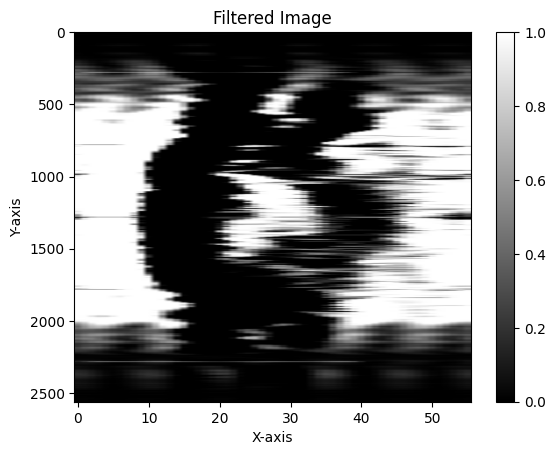

In [65]:
# Iterate over the images and plot each one
sample_img = np.load(file_list[4])
# Separate amplitude and frequency channels
amplitude = sample_img[:, :, 0]
frequency = sample_img[:, :, 1]

# Combine amplitude and frequency channels
combined_image = np.stack((amplitude, frequency), axis=-1)

# Create a zero-filled channel
zero_channel = np.zeros_like(amplitude)

# Merge amplitude, frequency, and zero-filled channels
final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

distance_img = np.abs(final_image)
# filter_img = hpbp_filter_signal_3d(distance_img)
# filter_img = bphp_filter_signal_3d(distance_img, 0.008, 0.1)
filter_img = bp_filter_signal_3d(distance_img, 0.008, 0.1)
filter_img = filter_img.clip(min=0)  # set minimum value to 0

# Plot the filtered image
plt.imshow(filter_img, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Wavelet

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image

def wavelet_transform(complex_img):
  # Perform the 2D Wavelet transform using the Haar wavelet
  coeffs = pywt.dwt2(complex_img, 'haar')

  # Get the approximation and detail coefficients
  cA, (cH, cV, cD) = coeffs

  # Calculate the magnitude of the complex numbers in the approximation coefficients
  mag_wav = np.abs(cA)

  # Normalize the magnitude to the range [0, 255]
  wavelet_img = 255.0 * mag_wav / np.max(mag_wav)

  return mag_wav

def wavelet_upsampling(complex_img, upsamp_factor=2):
  # Perform the 2D Wavelet transform using the Haar wavelet
  coeffs = pywt.dwt2(complex_img, 'haar')

  # Get the approximation and detail coefficients
  cA, (cH, cV, cD) = coeffs

  # Calculate the magnitude of the complex numbers in the approximation coefficients
  mag_wav = np.abs(cA)

  # Normalize the magnitude to the range [0, 255]
  wavelet_img = 255.0 * mag_wav / np.max(mag_wav)

  # Upsample the image
  wavelet_img = np.kron(wavelet_img, np.ones((upsamp_factor,upsamp_factor)))

  return wavelet_img


## Wavelet 3D

In [68]:
def wavelet_transform_3d(complex_img):
    """
    : Description :   Perform 2D Wavelet transform on each slice of a 3D image
    : Input :
      - complex_img   3D array of complex numbers
    : Output :
      - mag_wav       3D array of wavelet magnitudes
    """
    # Get the shape of the 3D image
    nz, ny, nx = complex_img.shape

    # Create an empty array for the wavelet magnitudes
    mag_wav = np.zeros((nz, ny // 2, nx // 2), dtype=np.float64)

    # Apply the wavelet transform to each 2D slice
    for i in range(nz):
        coeffs = pywt.dwt2(complex_img[i], 'haar')
        cA, (cH, cV, cD) = coeffs
        mag_wav[i] = np.abs(cA)

    return mag_wav

def wavelet_upsampling_3d(complex_img, upsamp_factor=2):
    """
    : Description :   Perform 2D Wavelet transform and upsample each slice of a 3D image
    : Input :
      - complex_img     3D array of complex numbers
      - upsamp_factor   Upsampling factor
    : Output :
      - wavelet_img     3D array of upsampled wavelet magnitudes
    """
    # Get the shape of the 3D image
    nz, ny, nx = complex_img.shape

    # Create an empty array for the upsampled wavelet magnitudes
    wavelet_img = np.zeros((nz, ny * upsamp_factor // 2, nx * upsamp_factor // 2), dtype=np.float64)

    # Apply the wavelet transform and upsample each 2D slice
    for i in range(nz):
        coeffs = pywt.dwt2(complex_img[i], 'haar')
        cA, (cH, cV, cD) = coeffs
        mag_wav = np.abs(cA)
        wavelet_img[i] = np.kron(mag_wav, np.ones((upsamp_factor, upsamp_factor)))

    # Normalize the magnitude to the range [0, 255]
    wavelet_img = 255.0 * wavelet_img / np.max(wavelet_img)

    return wavelet_img

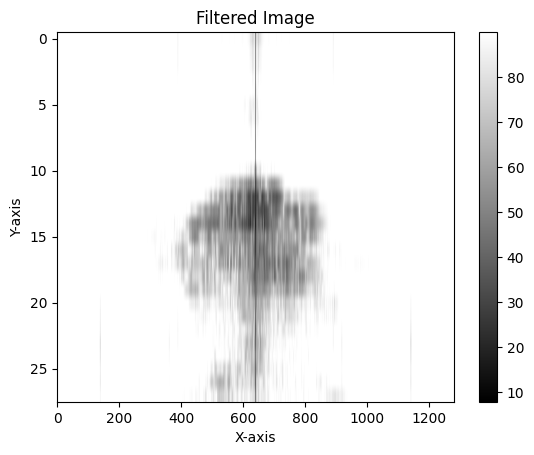

In [93]:
# sample_img = np.load(file_list[2])
# sample_img = np.sum(sample_img, axis=-1)
# distance_img = np.abs(sample_img)
# filter_img = wavelet_transform(distance_img)
# filter_img = np.transpose(filter_img)
# filter_img = filter_img.clip(min=0)

# # Plot the filtered image
# plt.imshow(filter_img, cmap='gray', aspect='auto')
# plt.colorbar()
# plt.title('Filtered Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

3D-array

In [70]:
# Sample usage
sample_img = np.load(file_list[4])
# Separate amplitude and frequency channels
amplitude = sample_img[:, :, 0]
frequency = sample_img[:, :, 1]

# Combine amplitude and frequency channels
combined_image = np.stack((amplitude, frequency), axis=-1)

# Create a zero-filled channel
zero_channel = np.zeros_like(amplitude)

# Merge amplitude, frequency, and zero-filled channels
final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

distance_img = np.abs(final_image)
filter_img = wavelet_transform_3d(distance_img)
filter_img = filter_img.clip(min=0)

# Plot the filtered image
plt.imshow(filter_img[0], cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

ValueError: could not broadcast input array from shape (28,2) into shape (28,1)

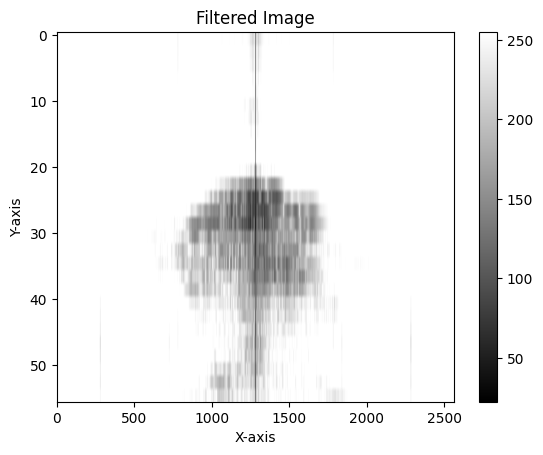

In [74]:
sample_img = np.load(file_list[2])
sample_img = np.sum(sample_img, axis=-1)
distance_img = np.abs(sample_img)
filter_img = wavelet_upsampling(distance_img)
filter_img = np.transpose(filter_img)
filter_img = filter_img.clip(min=0)

# Plot the filtered image
plt.imshow(filter_img, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Sliding range frequency (Optimized)

In [72]:
import numpy as np
from collections import deque

def range_time(IQ_data, n_rd_history=256):
    frames = []
    frame = deque(maxlen=n_rd_history)  # Use deque for the sliding window

    for iqini in IQ_data:
        # Ensure the input data is a complex number
        iqini = np.asarray(iqini, dtype=np.complex128)
        frame.append(iqini)
        if len(frame) == n_rd_history:
            frames.append(np.copy(frame))

    return np.stack(frames)

def range_frequency(datas):
    n = datas.shape[1]  # Number of range bins
    range_frequency_frame = np.zeros((datas.shape[0], n, datas.shape[2]), dtype=float)

    for i, data in enumerate(datas):
        # Ensure the input data is of type complex
        data = np.asarray(data, dtype=np.complex128)
        # Range-Doppler
        rd = np.fft.fft(data, axis=0)
        rd = np.fft.fftshift(rd, axes=0)
        rd = np.abs(rd)
        dbrd = 20 * np.log10(rd + 1e-10)
        range_frequency_frame[i] = dbrd

    return range_frequency_frame

def srf_transform(complex_img, half=False):
    # Ensure the input image is of type complex
    complex_img = np.asarray(complex_img, dtype=np.complex128)
    img = range_time(complex_img)
    img = range_frequency(img)
    if half:
        img = img[:, :img.shape[1] // 2, :]
    srf_img = img.reshape(img.shape[0] * img.shape[1], img.shape[2]).real
    return srf_img.T

## SRF 3D

In [74]:
import numpy as np
from collections import deque

def range_time(IQ_data, n_rd_history=256):
    frames = []
    frame = deque(maxlen=n_rd_history)  # Use deque for the sliding window

    for iqini in IQ_data:
        # Ensure the input data is a complex number
        iqini = np.asarray(iqini, dtype=np.complex128)
        frame.append(iqini)
        if len(frame) == n_rd_history:
            frames.append(np.copy(frame))

    return np.stack(frames)

def range_frequency(datas):
    n = datas.shape[1]  # Number of range bins
    range_frequency_frame = np.zeros((datas.shape[0], n, datas.shape[2]), dtype=float)

    for i, data in enumerate(datas):
        # Ensure the input data is of type complex
        data = np.asarray(data, dtype=np.complex128)
        # Range-Doppler
        rd = np.fft.fft(data, axis=0)
        rd = np.fft.fftshift(rd, axes=0)
        rd = np.abs(rd)
        dbrd = 20 * np.log10(rd + 1e-10)
        range_frequency_frame[i] = dbrd

    return range_frequency_frame

def srf_transform_3ch(complex_img, half=False):
    # Ensure the input image is of type complex
    complex_img = np.asarray(complex_img, dtype=np.complex128)

    # Process each channel separately
    transformed_channels = []
    for channel in range(complex_img.shape[-1]):
        img = range_time(complex_img[..., channel])
        img = range_frequency(img)
        if half:
            img = img[:, :img.shape[1] // 2, :]
        transformed_channels.append(img)

    # Stack transformed channels along the last axis
    transformed_img = np.stack(transformed_channels, axis=-1)

    # Reshape the image and take the real part
    srf_img = transformed_img.reshape(transformed_img.shape[0] * transformed_img.shape[1], transformed_img.shape[2], transformed_img.shape[3]).real

    # Transpose the image for proper orientation
    return srf_img.transpose(1, 0, 2)

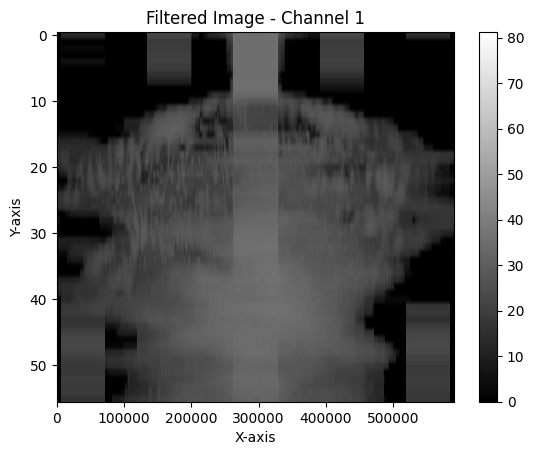

In [75]:
# Sample usage
sample_img = np.load(file_list[4])
# Separate amplitude, frequency, and zero-filled channels
amplitude = sample_img[:, :, 0]
frequency = sample_img[:, :, 1]
zero_channel = np.zeros_like(amplitude)

# Combine amplitude, frequency, and zero-filled channels
final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

# Apply the srf_transform_3ch function
srf_img = srf_transform_3ch(final_image)
srf_img = srf_img.clip(min=0)

# Plot the filtered image for one channel
plt.imshow(srf_img[:, :, 0], cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Filtered Image - Channel 1')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [73]:
sample_img = np.load(file_list[4])
sample_img = np.sum(sample_img, axis=-1)
print(sample_img.shape)
distance_img = np.abs(sample_img)
filter_img = srf_transform(distance_img)

# Plot the filtered image
plt.imshow(filter_img, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

ValueError: could not broadcast input array from shape (256,56,3) into shape (256,56)

In [80]:
# Convert the numpy array to a PIL Image
image_pil = Image.fromarray((filter_img * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

# Convert single-channel image to three-channel image
image_rgb = Image.merge("RGB", (image_pil, image_pil, image_pil))

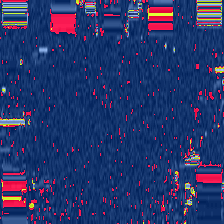

In [81]:
# Display an example of transform images
toImage(transforms["train"](image_rgb))

## Pipeline for preprocess the image

* Normal one

In [25]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_and_save_image(file_path, output_dir):

    # Load the image array
    image_array = np.load(file_path)

    # Separate amplitude and frequency channels
    amplitude = image_array[:, :, 0]
    frequency = image_array[:, :, 1]

    # Combine amplitude and frequency channels
    combined_image = np.stack((amplitude, frequency), axis=-1)

    # Create a zero-filled channel
    zero_channel = np.zeros_like(amplitude)

    # Merge amplitude, frequency, and zero-filled channels
    final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

    # Convert the numpy array to a PIL Image
    image_pil = Image.fromarray((final_image * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

    # Save the image
    file_name = os.path.basename(file_path).replace('.npy', '.png')
    output_path = os.path.join(output_dir, file_name)
    image_pil.save(output_path)
    
    return output_path

def process_and_save_images(npy_files, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    saved_images = []
    
    for file_path in tqdm(npy_files, desc="Processing Images"):  # Use TQDM to track the process
        output_path = process_and_save_image(file_path, output_dir)
        saved_images.append(output_path)
    
    return saved_images

# Example usage
npy_directory = "/kaggle/input/signal-pose-prediction/train/train"
output_directory = "/kaggle/working/processed_images"
npy_files = [os.path.join(npy_directory, file) for file in os.listdir(npy_directory) if file.endswith('.npy')]

# Process and save images with progress bar
saved_images = process_and_save_images(npy_files, output_directory)

Processing Images: 100%|██████████| 647/647 [00:29<00:00, 22.07it/s]


## SRF Transform

In [76]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_and_save_image(file_path, output_dir):

    # Load the image array
    image_array = np.load(file_path)

    # Separate amplitude and frequency channels
    amplitude = image_array[:, :, 0]
    frequency = image_array[:, :, 1]

    # Combine amplitude and frequency channels
    combined_image = np.stack((amplitude, frequency), axis=-1)

    # Create a zero-filled channel
    zero_channel = np.zeros_like(amplitude)

    # Merge amplitude, frequency, and zero-filled channels
    final_image = np.stack((amplitude, frequency, zero_channel), axis=-1)

    distance_img = np.abs(final_image)
    # filter_img = hpbp_filter_signal_3d(distance_img)
    # filter_img = bphp_filter_signal_3d(distance_img, 0.008, 0.1)
    filter_img = bp_filter_signal_3d(distance_img, 0.008, 0.1)
    filter_img = filter_img.clip(min=0)  # set minimum value to 0

    # Convert the numpy array to a PIL Image
    image_pil = Image.fromarray((filter_img * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

    # Save the image
    file_name = os.path.basename(file_path).replace('.npy', '.png')
    output_path = os.path.join(output_dir, file_name)
    image_pil.save(output_path)
    
    return output_path

def process_and_save_images(npy_files, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    saved_images = []
    
    for file_path in tqdm(npy_files, desc="Processing Images"):  # Use TQDM to track the process
        output_path = process_and_save_image(file_path, output_dir)
        saved_images.append(output_path)
    
    return saved_images

# Example usage
npy_directory = "/kaggle/input/signal-pose-prediction/train/train"
output_directory = "/kaggle/working/processed_images"
npy_files = [os.path.join(npy_directory, file) for file in os.listdir(npy_directory) if file.endswith('.npy')]

# Process and save images with progress bar
saved_images = process_and_save_images(npy_files, output_directory)

Processing Images: 100%|██████████| 647/647 [01:16<00:00,  8.43it/s]


### Compressed

In [26]:
# import os
# from PIL import Image
# from tqdm import tqdm

# def compress_images(input_dir, output_dir, quality=85, optimize=True):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

#     for filename in tqdm(image_files, desc="Compressing Images"):
#         input_path = os.path.join(input_dir, filename)
#         output_path = os.path.join(output_dir, filename)

#         try:
#             img = Image.open(input_path)

#             if filename.lower().endswith(('.jpg', '.jpeg')):
#                 img = img.convert('RGB')
#                 img.save(output_path, "JPEG", quality=quality)
#             elif filename.lower().endswith('.png'):
#                 img.save(output_path, "PNG", optimize=optimize)
#             elif filename.lower().endswith('.webp'):
#                 img.save(output_path, "WEBP", quality=quality, lossless=False)
#             else:
#                 print(f"Unsupported file type: {filename}")

#         except Exception as e:
#             print(f"Error processing {filename}: {e}")

# # Example usage:
# input_folder = "/kaggle/working/processed_images"
# output_folder = "/kaggle/working/processed_images"

# compress_images(input_folder, output_folder)

Also for the test datasets.

In [77]:
# Example usage
npy_directory = "/kaggle/input/signal-pose-prediction/test/test"
output_directory = "/kaggle/working/test_images"
npy_files = [os.path.join(npy_directory, file) for file in os.listdir(npy_directory) if file.endswith('.npy')]

# Process and save images
saved_images = process_and_save_images(npy_files, output_directory)

Processing Images: 100%|██████████| 164/164 [00:19<00:00,  8.46it/s]


In [78]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file)  # Load CSV file
        self.image_names = self.df["id"].values  # Assuming column name is 'image_name'
        self.labels = self.df["class"].values  # Assuming column name is 'class'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name + ".png")  # Ensure the file has .png extension
        
        if not os.path.exists(img_path):  # Check if file exists
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = Image.open(img_path).convert("RGB")  # Open image
        label = self.labels[idx]  # Get label

        if self.transform:
            image = self.transform(image)  # Apply transforms

        return image, torch.tensor(label, dtype=torch.long)  # Return image and label

## Dataset Loading

In [109]:
# Assign dataset from train signal
dataset = ImageDataset("/kaggle/working/processed_images", "/kaggle/input/signal-pose-prediction/train.csv", transform=transforms["train"])

In [110]:
# List all available models
# timm.list_models("")

In [111]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
# Select model (List of available is shown above)
# model_name = "hf_hub:timm/maxvit_base_tf_224.in1k"
# model_name = "convnextv2_tiny"
model_name = "hf_hub:timm/levit_256.fb_dist_in1k"
#model_name = "hf_hub:timm/seresnextaa101d_32x8d.sw_in12k_ft_in1k_288"

In [112]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("f1")

In [113]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [114]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 8
eval_batch_size = 16
num_accumulate = 4

In [115]:
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of 5")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=7).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)                           # update the slow weight every k steps
                                                                                          # update the optimizer by combine slow weight and fast weight * alpha

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            loss.backward()

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
                
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###

        optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###

        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
            print("New Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"checkpoint_fold{fold}.pt")

        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/76.0M [00:00<?, ?B/s]

100%|██████████| 9/9 [00:01<00:00,  4.74it/s]


New Best Score!
{'metric_train': [0.3217324975207446], 'metric_val': [0.20268246622926428], 'train_loss': [1.7054164482997014], 'val_loss': [6.450974153147803], 'best_metric_val': 0.20268246622926428}
Fold: 0 | Epoch: 0 | Metric: 0.20268246622926428 | Training Loss: 1.7054164482997014 | Validation Loss: 6.450974153147803


100%|██████████| 9/9 [00:01<00:00,  4.71it/s]


New Best Score!
{'metric_train': [0.3217324975207446, 0.4027201832515096], 'metric_val': [0.20268246622926428, 0.26646341683935665], 'train_loss': [1.7054164482997014, 1.40202077627182], 'val_loss': [6.450974153147803, 11.322296023368835], 'best_metric_val': 0.26646341683935665}
Fold: 0 | Epoch: 1 | Metric: 0.26646341683935665 | Training Loss: 1.40202077627182 | Validation Loss: 11.322296023368835


100%|██████████| 9/9 [00:01<00:00,  4.68it/s]


New Best Score!
{'metric_train': [0.3217324975207446, 0.4027201832515096, 0.46180339606521903], 'metric_val': [0.20268246622926428, 0.26646341683935665, 0.4557841251326014], 'train_loss': [1.7054164482997014, 1.40202077627182, 1.2572695732116699], 'val_loss': [6.450974153147803, 11.322296023368835, 1.4654539691077337], 'best_metric_val': 0.4557841251326014}
Fold: 0 | Epoch: 2 | Metric: 0.4557841251326014 | Training Loss: 1.2572695732116699 | Validation Loss: 1.4654539691077337


100%|██████████| 9/9 [00:01<00:00,  4.66it/s]


New Best Score!
{'metric_train': [0.3217324975207446, 0.4027201832515096, 0.46180339606521903, 0.5953985267438092], 'metric_val': [0.20268246622926428, 0.26646341683935665, 0.4557841251326014, 0.47014522939461406], 'train_loss': [1.7054164482997014, 1.40202077627182, 1.2572695732116699, 1.0958239454489487], 'val_loss': [6.450974153147803, 11.322296023368835, 1.4654539691077337, 4.759142071008682], 'best_metric_val': 0.47014522939461406}
Fold: 0 | Epoch: 3 | Metric: 0.47014522939461406 | Training Loss: 1.0958239454489487 | Validation Loss: 4.759142071008682


100%|██████████| 9/9 [00:01<00:00,  4.73it/s]


New Best Score!
{'metric_train': [0.3217324975207446, 0.4027201832515096, 0.46180339606521903, 0.5953985267438092, 0.5831727921135063], 'metric_val': [0.20268246622926428, 0.26646341683935665, 0.4557841251326014, 0.47014522939461406, 0.4847980053039009], 'train_loss': [1.7054164482997014, 1.40202077627182, 1.2572695732116699, 1.0958239454489487, 1.0586270827513475], 'val_loss': [6.450974153147803, 11.322296023368835, 1.4654539691077337, 4.759142071008682, 4.49239585796992], 'best_metric_val': 0.4847980053039009}
Fold: 0 | Epoch: 4 | Metric: 0.4847980053039009 | Training Loss: 1.0586270827513475 | Validation Loss: 4.49239585796992
Fold 2 of 5


100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


New Best Score!
{'metric_train': [0.3104347786109271], 'metric_val': [0.1577832212507135], 'train_loss': [1.6643000987859873], 'val_loss': [2.5366101099385157], 'best_metric_val': 0.1577832212507135}
Fold: 1 | Epoch: 0 | Metric: 0.1577832212507135 | Training Loss: 1.6643000987859873 | Validation Loss: 2.5366101099385157


100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


New Best Score!
{'metric_train': [0.3104347786109271, 0.3505881896424915], 'metric_val': [0.1577832212507135, 0.32429858747017865], 'train_loss': [1.6643000987859873, 1.4141697140840384], 'val_loss': [2.5366101099385157, 2.567861404683855], 'best_metric_val': 0.32429858747017865}
Fold: 1 | Epoch: 1 | Metric: 0.32429858747017865 | Training Loss: 1.4141697140840384 | Validation Loss: 2.567861404683855


100%|██████████| 9/9 [00:01<00:00,  4.81it/s]


{'metric_train': [0.3104347786109271, 0.3505881896424915, 0.5160261580630701], 'metric_val': [0.1577832212507135, 0.32429858747017865, 0.3073985287895062], 'train_loss': [1.6643000987859873, 1.4141697140840384, 1.2100820486362165], 'val_loss': [2.5366101099385157, 2.567861404683855, 8.587949103779263], 'best_metric_val': 0.32429858747017865}
Fold: 1 | Epoch: 2 | Metric: 0.3073985287895062 | Training Loss: 1.2100820486362165 | Validation Loss: 8.587949103779263


100%|██████████| 9/9 [00:01<00:00,  4.85it/s]


New Best Score!
{'metric_train': [0.3104347786109271, 0.3505881896424915, 0.5160261580630701, 0.6000357834833538], 'metric_val': [0.1577832212507135, 0.32429858747017865, 0.3073985287895062, 0.5122610535134036], 'train_loss': [1.6643000987859873, 1.4141697140840384, 1.2100820486362165, 1.1123395864780132], 'val_loss': [2.5366101099385157, 2.567861404683855, 8.587949103779263, 6.3604058557086525], 'best_metric_val': 0.5122610535134036}
Fold: 1 | Epoch: 3 | Metric: 0.5122610535134036 | Training Loss: 1.1123395864780132 | Validation Loss: 6.3604058557086525


100%|██████████| 9/9 [00:01<00:00,  4.71it/s]


New Best Score!
{'metric_train': [0.3104347786109271, 0.3505881896424915, 0.5160261580630701, 0.6000357834833538, 0.6623985437341273], 'metric_val': [0.1577832212507135, 0.32429858747017865, 0.3073985287895062, 0.5122610535134036, 0.556407736254675], 'train_loss': [1.6643000987859873, 1.4141697140840384, 1.2100820486362165, 1.1123395864780132, 0.9531129717826843], 'val_loss': [2.5366101099385157, 2.567861404683855, 8.587949103779263, 6.3604058557086525, 1.2456191447046068], 'best_metric_val': 0.556407736254675}
Fold: 1 | Epoch: 4 | Metric: 0.556407736254675 | Training Loss: 0.9531129717826843 | Validation Loss: 1.2456191447046068
Fold 3 of 5


100%|██████████| 9/9 [00:01<00:00,  4.75it/s]


New Best Score!
{'metric_train': [0.27553053732949534], 'metric_val': [0.1606369820655535], 'train_loss': [1.716214968607976], 'val_loss': [34.48173398441739], 'best_metric_val': 0.1606369820655535}
Fold: 2 | Epoch: 0 | Metric: 0.1606369820655535 | Training Loss: 1.716214968607976 | Validation Loss: 34.48173398441739


100%|██████████| 9/9 [00:01<00:00,  4.79it/s]


New Best Score!
{'metric_train': [0.27553053732949534, 0.4035571808531386], 'metric_val': [0.1606369820655535, 0.2930420653109729], 'train_loss': [1.716214968607976, 1.4316927588902988], 'val_loss': [34.48173398441739, 22.24599591890971], 'best_metric_val': 0.2930420653109729}
Fold: 2 | Epoch: 1 | Metric: 0.2930420653109729 | Training Loss: 1.4316927588902988 | Validation Loss: 22.24599591890971


100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


New Best Score!
{'metric_train': [0.27553053732949534, 0.4035571808531386, 0.4602045856351416], 'metric_val': [0.1606369820655535, 0.2930420653109729, 0.43307524308424666], 'train_loss': [1.716214968607976, 1.4316927588902988, 1.2385550654851474], 'val_loss': [34.48173398441739, 22.24599591890971, 10.44757533735699], 'best_metric_val': 0.43307524308424666}
Fold: 2 | Epoch: 2 | Metric: 0.43307524308424666 | Training Loss: 1.2385550654851474 | Validation Loss: 10.44757533735699


100%|██████████| 9/9 [00:01<00:00,  4.70it/s]


New Best Score!
{'metric_train': [0.27553053732949534, 0.4035571808531386, 0.4602045856351416, 0.5132972543367326], 'metric_val': [0.1606369820655535, 0.2930420653109729, 0.43307524308424666, 0.4743782533256217], 'train_loss': [1.716214968607976, 1.4316927588902988, 1.2385550654851474, 1.1457158767260038], 'val_loss': [34.48173398441739, 22.24599591890971, 10.44757533735699, 16.453637619813282], 'best_metric_val': 0.4743782533256217}
Fold: 2 | Epoch: 3 | Metric: 0.4743782533256217 | Training Loss: 1.1457158767260038 | Validation Loss: 16.453637619813282


100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


{'metric_train': [0.27553053732949534, 0.4035571808531386, 0.4602045856351416, 0.5132972543367326, 0.5569965649162097], 'metric_val': [0.1606369820655535, 0.2930420653109729, 0.43307524308424666, 0.4743782533256217, 0.4363493172991763], 'train_loss': [1.716214968607976, 1.4316927588902988, 1.2385550654851474, 1.1457158767260038, 1.0783666253089905], 'val_loss': [34.48173398441739, 22.24599591890971, 10.44757533735699, 16.453637619813282, 39.46571246120665], 'best_metric_val': 0.4743782533256217}
Fold: 2 | Epoch: 4 | Metric: 0.4363493172991763 | Training Loss: 1.0783666253089905 | Validation Loss: 39.46571246120665
Fold 4 of 5


100%|██████████| 9/9 [00:01<00:00,  4.81it/s]


New Best Score!
{'metric_train': [0.2967255643121213], 'metric_val': [0.26564344809107504], 'train_loss': [1.7214408195935762], 'val_loss': [6.163411570919885], 'best_metric_val': 0.26564344809107504}
Fold: 3 | Epoch: 0 | Metric: 0.26564344809107504 | Training Loss: 1.7214408195935762 | Validation Loss: 6.163411570919885


100%|██████████| 9/9 [00:01<00:00,  4.81it/s]


New Best Score!
{'metric_train': [0.2967255643121213, 0.4191606378158023], 'metric_val': [0.26564344809107504, 0.3437770121730662], 'train_loss': [1.7214408195935762, 1.3937521072534413], 'val_loss': [6.163411570919885, 119.47405109802882], 'best_metric_val': 0.3437770121730662}
Fold: 3 | Epoch: 1 | Metric: 0.3437770121730662 | Training Loss: 1.3937521072534413 | Validation Loss: 119.47405109802882


100%|██████████| 9/9 [00:01<00:00,  4.70it/s]


New Best Score!
{'metric_train': [0.2967255643121213, 0.4191606378158023, 0.5365767920166796], 'metric_val': [0.26564344809107504, 0.3437770121730662, 0.5035903903276939], 'train_loss': [1.7214408195935762, 1.3937521072534413, 1.263352981897501], 'val_loss': [6.163411570919885, 119.47405109802882, 3.439348432752821], 'best_metric_val': 0.5035903903276939}
Fold: 3 | Epoch: 2 | Metric: 0.5035903903276939 | Training Loss: 1.263352981897501 | Validation Loss: 3.439348432752821


100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


New Best Score!
{'metric_train': [0.2967255643121213, 0.4191606378158023, 0.5365767920166796, 0.6316944729728299], 'metric_val': [0.26564344809107504, 0.3437770121730662, 0.5035903903276939, 0.538296669099963], 'train_loss': [1.7214408195935762, 1.3937521072534413, 1.263352981897501, 1.0860684532385605], 'val_loss': [6.163411570919885, 119.47405109802882, 3.439348432752821, 2.194818056292004], 'best_metric_val': 0.538296669099963}
Fold: 3 | Epoch: 3 | Metric: 0.538296669099963 | Training Loss: 1.0860684532385605 | Validation Loss: 2.194818056292004


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


{'metric_train': [0.2967255643121213, 0.4191606378158023, 0.5365767920166796, 0.6316944729728299, 0.6782891419743324], 'metric_val': [0.26564344809107504, 0.3437770121730662, 0.5035903903276939, 0.538296669099963, 0.538199041195935], 'train_loss': [1.7214408195935762, 1.3937521072534413, 1.263352981897501, 1.0860684532385605, 0.9476284714845511], 'val_loss': [6.163411570919885, 119.47405109802882, 3.439348432752821, 2.194818056292004, 1.193207813633813], 'best_metric_val': 0.538296669099963}
Fold: 3 | Epoch: 4 | Metric: 0.538199041195935 | Training Loss: 0.9476284714845511 | Validation Loss: 1.193207813633813
Fold 5 of 5


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


New Best Score!
{'metric_train': [0.2451809469903973], 'metric_val': [0.23050225562730545], 'train_loss': [1.7522570389967698], 'val_loss': [15.163807060983446], 'best_metric_val': 0.23050225562730545}
Fold: 4 | Epoch: 0 | Metric: 0.23050225562730545 | Training Loss: 1.7522570389967698 | Validation Loss: 15.163807060983446


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


{'metric_train': [0.2451809469903973, 0.3571198979217855], 'metric_val': [0.23050225562730545, 0.19510751820498148], 'train_loss': [1.7522570389967698, 1.5040194768172044], 'val_loss': [15.163807060983446, 4.437682999504937], 'best_metric_val': 0.23050225562730545}
Fold: 4 | Epoch: 1 | Metric: 0.19510751820498148 | Training Loss: 1.5040194768172044 | Validation Loss: 4.437682999504937


100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


New Best Score!
{'metric_train': [0.2451809469903973, 0.3571198979217855, 0.3984101096322023], 'metric_val': [0.23050225562730545, 0.19510751820498148, 0.42531256250692706], 'train_loss': [1.7522570389967698, 1.5040194768172044, 1.3562685122856728], 'val_loss': [15.163807060983446, 4.437682999504937, 3.401171233918932], 'best_metric_val': 0.42531256250692706}
Fold: 4 | Epoch: 2 | Metric: 0.42531256250692706 | Training Loss: 1.3562685122856728 | Validation Loss: 3.401171233918932


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


New Best Score!
{'metric_train': [0.2451809469903973, 0.3571198979217855, 0.3984101096322023, 0.4796304834639016], 'metric_val': [0.23050225562730545, 0.19510751820498148, 0.42531256250692706, 0.512134932094633], 'train_loss': [1.7522570389967698, 1.5040194768172044, 1.3562685122856728, 1.2226446692760173], 'val_loss': [15.163807060983446, 4.437682999504937, 3.401171233918932, 3.578416579299503], 'best_metric_val': 0.512134932094633}
Fold: 4 | Epoch: 3 | Metric: 0.512134932094633 | Training Loss: 1.2226446692760173 | Validation Loss: 3.578416579299503


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


New Best Score!
{'metric_train': [0.2451809469903973, 0.3571198979217855, 0.3984101096322023, 0.4796304834639016, 0.5903344131929165], 'metric_val': [0.23050225562730545, 0.19510751820498148, 0.42531256250692706, 0.512134932094633, 0.5125247044191144], 'train_loss': [1.7522570389967698, 1.5040194768172044, 1.3562685122856728, 1.2226446692760173, 1.1343537743274983], 'val_loss': [15.163807060983446, 4.437682999504937, 3.401171233918932, 3.578416579299503, 2.783859497971005], 'best_metric_val': 0.5125247044191144}
Fold: 4 | Epoch: 4 | Metric: 0.5125247044191144 | Training Loss: 1.1343537743274983 | Validation Loss: 2.783859497971005


<ipython-input-116-76bfe0517d95>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 9/9

Fold: 0


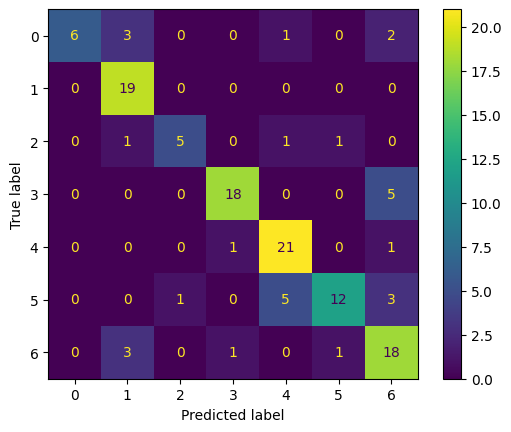

<ipython-input-116-76bfe0517d95>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 9/9

Fold: 1


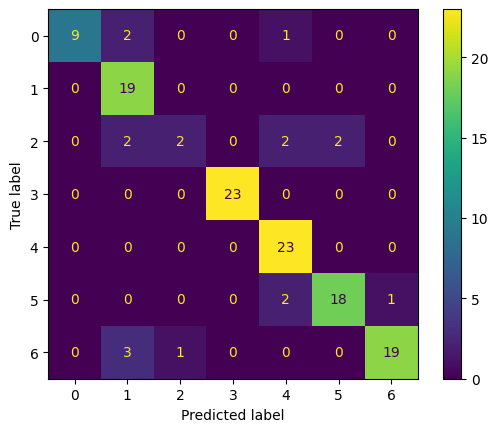

<ipython-input-116-76bfe0517d95>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 9/9

Fold: 2


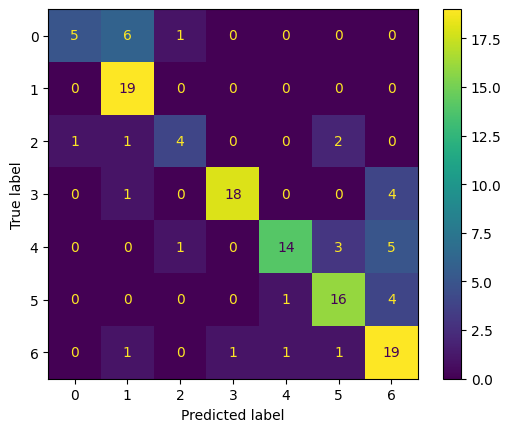

<ipython-input-116-76bfe0517d95>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 9/9

Fold: 3


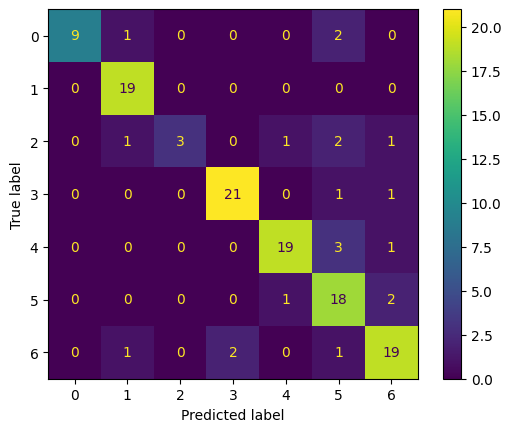

<ipython-input-116-76bfe0517d95>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 9/9

Fold: 4


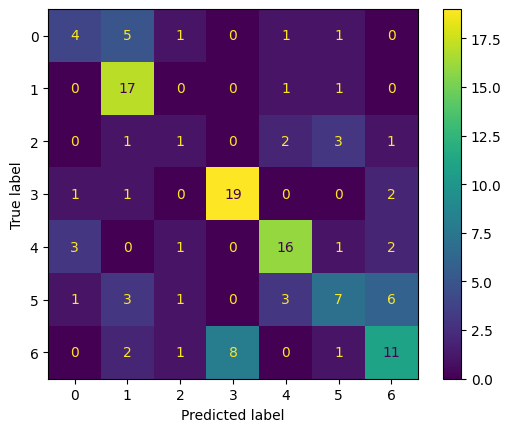

In [116]:
for fold in range(k_splits):
    predictions = []
    references = []
    
    # load model
    loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
    # Evaluation
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))
    
            # Log Values
            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()
    
    print(f"Fold: {fold}")
    
    # Confusion matrix
    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    

In [102]:
test_files_list = []

test_files = glob.glob("/kaggle/working/test_images/*")
test_files_list.append(test_files)
test_files_list = [item for sublist in test_files_list for item in sublist]

In [111]:
# test_files_list

In [117]:
answers_final = dict()

# Loop for each fold
for fold in range(5):
    # load model
    loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")

    # Evaluation
    model.eval() 
    with torch.no_grad():
        for f in tqdm(test_files_list):
            key = f.split("/")[-1].split(".")[0]
            
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            # Collect all predicted value of each fold
            if fold == 0:
                answers_final[key] = [loaded_model(transformed).argmax(-1).item()]
            else:
                answers_final[key].append(loaded_model(transformed).argmax(-1).item())

<ipython-input-117-ea43361db25f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")
100%|██████████| 164

In [118]:
# for key in answers_final:
#     # Take most occuring number to be answer
#     answers_final[key] = stats.mode(answers_final[key])[0][0]

In [118]:
import pandas as pd
from collections import Counter

# Convert dictionary to DataFrame
df = pd.DataFrame(list(answers_final.items()), columns=['id', 'votes'])

# Function to determine the most common number
def most_common(votes):
    return Counter(votes).most_common(1)[0][0]

# Apply the function to the votes column
df['class'] = df['votes'].apply(most_common)

# Display the new DataFrame
df.head(5)

,id,votes,class
0,63f074b1-95d6-453f-a5bd-513cc428ebf8,"[2, 0, 0, 2, 2]",2
1,eb43382d-9425-4a65-846b-e40affccae18,"[5, 4, 5, 5, 4]",5
2,aa851836-415b-4a18-b660-99a395976285,"[3, 3, 1, 3, 3]",3
3,17445f56-bd54-43f0-9560-db427817b8e6,"[4, 4, 4, 5, 4]",4
4,e11d7c9a-c3dc-4be5-bfc1-5b2a04dee433,"[5, 5, 5, 5, 6]",5


In [119]:
df['class'].value_counts()

class
3    36
1    36
4    32
6    32
5    18
0     7
2     3
Name: count, dtype: int64

In [120]:
df.drop("votes", inplace=True, axis=1 )

In [121]:
df.to_csv('submission_signal_levit.csv', index=False)

In [113]:
answer_final

NameError: name 'answer_final' is not defined

In [ ]:
# save result of voting technique
with open(f"solution_maxvit_kfold{k_splits}_voting.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

In [ ]:
answers_final = dict()

# Loop for each fold
for fold in range(k_splits):
    # load model
    loaded_model = torch.load(f"/kaggle/working/checkpoint_fold{fold}.pt")

    # evaluation
    model.eval() 
    with torch.no_grad():
        for f in tqdm(test_files_list):
            key = f.split("/")[-1].split(".")[0]
   
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            # Collect all predicted value of each fold "AND" multiply them with their evaluation scores
            if fold == 0:
                answers_final[key] = loaded_model(transformed).cpu().numpy() * all_eval_scores[fold]
            else:
                answers_final[key] = answers_final[key] + (loaded_model(transformed).cpu().numpy() * all_eval_scores[fold])

answers_raw = copy(answers_final)

for key in answers_final:
    # Take most occuring number 
    answers_final[key] = np.argmax(answers_final[key], -1).item()

In [ ]:
# save result of voting technique
with open(f"solution_maxvit_kfold{k_splits}_weighted.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

---

In [125]:
# Prepare softmax layer
softmax = nn.Softmax()

In [127]:
answers_raw = copy(answers_final)

In [128]:
import torch
import numpy as np

to_move = {x: [] for x in range(7)}
threshold = 0.9   # How confidence of each answering

for key in answers_raw:
    # Get the predicted class index by considering the most probability value
    predicted_class = np.argmax(answers_raw[key], -1).item()

    # Apply softmax along the appropriate dimension
    softmax_probs = torch.nn.functional.softmax(torch.tensor(answers_raw[key]), dim=-1)

    # If the model's confidence in the answer is more than the threshold, collect it
    if softmax_probs[0, predicted_class].item() > threshold:
        to_move[predicted_class].append(key)


RuntimeError: "softmax_lastdim_kernel_impl" not implemented for 'Long'

In [ ]:
print(f"/kaggle/input/ultra-wide-band-pose-prediction/train/train{file_name}")

In [ ]:
# Copy confidence data to training set
for pred_class in to_move:
    for item in to_move[pred_class]:
        file_name = item.split("/")[-1]
        shutil.copyfile(item, f"/kaggle/input/ultra-wide-band-pose-prediction/train/train/{file_name}")

4

In [ ]:
import os
os.remove("/kaggle/working/solution_maxvit_kfold5_voting.csv")

In [ ]:
df = pd.read_csv('/kaggle/input/voting/voting.csv')
df.to_csv('voting.csv', index=False)

In [ ]:
# Get all result data in csv format
all_submissions = glob.glob("*.csv")
print(all_submissions)

In [ ]:
all_answers = dict()

# Combine all predicted value from each csv
for idx, submission in enumerate(all_submissions):
    # read result csv
    df = pd.read_csv(submission)
    # convert csv to dictionary
    mapper = {}
    for i in range(len(df)):
        mapper[df.id[i]] = df['class'][i]
    # add each predicted value in to list
    for key in mapper:
        if idx == 0:
            all_answers[key] = [mapper[key]]
        else:
            all_answers[key].append(mapper[key])

In [ ]:
#all_answers

In [ ]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(list(all_answers.items()), columns=['id', 'class'])

# Save DataFrame to CSV file
df.to_csv('output.csv', index=False)


In [ ]:
real_answers = {}
# loop for all answer
for key in all_answers:
    # Take most occuring number 
    real_answers[key] = stats.mode(all_answers[key])[0][0]

In [ ]:
# Save final result
with open(f"no1-3.0.csv", "w") as f:
    f.write("id,class\n")
    for name in real_answers:
        f.write(f"{name},{real_answers[name]}\n")

# **More Code Here:**
https://drive.google.com/drive/folders/1xUQA1d84l_00y5ECtkGMYK8Wgs7RW0BI?usp=sharing

In the drive, there are SignalPreparation.ipynb and OutputPreparation.ipynb

> SignalPreparation.ipynb is used for preprocessing signal data, while OutputPreparation.ipynb is used for cleaning output (.csv) data.

<figure>
        <img src="https://i.pinimg.com/originals/3d/2c/21/3d2c218daee0f7ac74abcea53d794e0d.gif" alt ="Audio Art" style='width:800px;height:500px;'>
        <figcaption>
            Yo Da Yoooo
        </figcaption>
</figure>